# Controlled Random Search Applied to Magnetometric Inversion Data
<hr>
<h4>This is a new version in python/jupyter from the fortran project in my github repository</h4>

This first part will be focused in delivering the direct model

In [1]:
import pandas as pd

In [2]:
# Importing the input in a pandas DataFrame
anomaly = pd.read_csv('Exercicio/anomalia.txt', delim_whitespace = True, header = None)
anomaly.columns = ['xp', 'anom']
# The first columns refers to the x coordinator of the profile; anom is the magnetic anomaly value
anomaly.head()

,xp,anom
0,0.0,2.181409
1,1.0,-0.578408
2,2.0,-2.168885
3,3.0,-2.268292
4,4.0,-1.875124


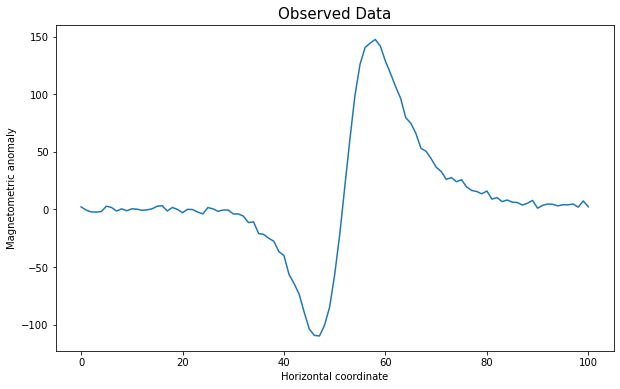

In [3]:
#Let's make a vizual of the profile

import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.xlabel('Horizontal coordinate')
plt.ylabel('Magnetometric anomaly')
plt.title('Observed Data', fontsize = 15)
plt.plot(anomaly.iloc[:,0], anomaly.iloc[:,1])

<p> From this observed data we have to estimate some properties of the body 
 that is generating this pattern shown in the figure above. </p>
 <p> The properties are: <b>xq</b> (horizontal distance coordinate), <b>zq</b> (depth) e <b>mom</b> (magnetic dipole moment). </p>
 <p>First, we will need to build a function that will generate the values for the anomaly pattern given the properties  mentioned above.</p>

In [4]:
# To the total field calculation, we need the components of the regional field
import numpy as np

def dircos(incl, decl):
    """
    incl = inclinação da magnetização (graus, positivo abaixo da horizontal) 
    decl = declinação da magnetização (graus, positiva para Leste, a partir do Norte verdadeiro)
    
    """
    
    d2rad = np.pi / 180
    xincl = incl*d2rad
    xdecl = decl*d2rad
    a = np.cos(xincl)*np.cos(xdecl)
    b = np.cos(xincl)*np.sin(xdecl)
    c = np.sin(xincl)
    return a, b, c

In [5]:
def dipole(xq,yq,zq,mi,md,moment,xp,yp,zp):
    
    """
    VARIAVEIS UTILIZADAS
    xp,yp e zp = COORDENADAS DO PONTO DE OBSERVAÇÃO (metros)
    xq,yq,zq = coordenadas do centro da esfera (metros)
    mi = inclinação da magnetização (graus, positivo abaixo da horizontal)
    md = declinação da magnetização (graus, positiva para Leste, a partir do Norte verdadeiro)
    moment = momento de dipolo magnetico (A.m²) 
    bx,by,bz,t = elementos do campo B gerados delo dipolo - dado de saida (nT)
    eixo x, na direção Norte
    eixo y, na direção Leste
    eixo z, para baixo
    """
    
    mx, my, mz = dircos(mi, md)
    rx = xp - xq
    ry = yp - yq
    rz = zp - zq
    r2 = rx**2 + ry**2 + rz**2
    r = np.sqrt(r2)
    #assert r =! 0, f"DIPOLE: bad argument detected."
    r5 = r**5
    dot = rx*mx + ry*my + rz*mz
    bx = 1e-7*moment*(3*dot*rx - r2*mx) / r5
    by = 1e-7*moment*(3*dot*ry - r2*my) / r5
    bz = 1e-7*moment*(3*dot*rz - r2*mz) / r5
    bx = bx*1e9
    by = by*1e9
    bz = bz*1e9
    
    return bx, by, bz

With the funtion that is the direct model, let's build the a implementation of the CSR algoritm 
that will solve our problem of estimate a model that fit our observed data

In [6]:
obs_data = np.asanyarray(anomaly)

In [7]:
# Setting the variables to this especific problem
# As medidas foram feitas a uma altura de 1m do solo (zp = -1m).
# yq and yp = 0, because we are considering only the profile in the x direction
zp = -1
yq = 0
yp = 0

In [8]:
# Setting the box that will be the search area to the algorithm
# The values will be chosen in a arbitrarily way
xqmin = 5
xqmax = 15
zqmin = 0
zqmax = 30
mmin = 1400
mmax = 1900

In [9]:
# The number of initial models are generaly  7 * n parameters (n = 3 in our case)
# It can be different, but let's test 7 first
n_modelos = 21

In [10]:
# Evaluating the initial models in a random way 
import random

conj_sol = np.zeros((3, n_modelos))

for i in range(n_modelos):
    conj_sol[0, i] = random.random()*(xqmax-xqmin) + xqmin
    conj_sol[1, i] = random.random()*(zqmax-zqmin) + zqmin
    conj_sol[2, i] = random.random()*(mmax-mmin) + mmin
conj_sol

array([[8.58888505e+00, 7.16253279e+00, 6.91381460e+00, 8.46578222e+00,
        1.10332418e+01, 1.49795122e+01, 1.31304575e+01, 1.18320687e+01,
        6.82181166e+00, 7.32662943e+00, 1.12146947e+01, 1.36565332e+01,
        1.35885315e+01, 5.08005368e+00, 1.08383884e+01, 1.44458798e+01,
        8.82919459e+00, 8.14189026e+00, 8.70484736e+00, 7.40437980e+00,
        7.71066691e+00],
       [2.17317442e+01, 1.99099596e+01, 6.13610646e+00, 1.11750395e+00,
        1.50793783e+01, 1.81059666e+01, 2.53869453e+01, 1.34413231e+00,
        1.82390769e+01, 1.90970201e+01, 2.24524089e+01, 2.61206968e+01,
        2.54857905e+01, 2.22557955e+01, 1.36542863e+01, 2.77392052e+01,
        1.47822700e+01, 7.86798850e+00, 1.11094477e+01, 2.53424324e+01,
        6.12736682e+00],
       [1.64208865e+03, 1.57165875e+03, 1.82615115e+03, 1.59815989e+03,
        1.45319473e+03, 1.47515551e+03, 1.89749579e+03, 1.65878466e+03,
        1.69752533e+03, 1.72141626e+03, 1.81970418e+03, 1.48392237e+03,
        1.8673

In [11]:
# Beggining the iterative process 
# We will get n=3 models randomly from the set 
# And we will make a mean of them

k = random.randint(0,n_modelos - 1)
l = random.randint(0,n_modelos - 1)
m = random.randint(0,n_modelos - 1)

k, l, m

(12, 18, 18)

In [12]:
# Building the mean from the models collected
P = np.zeros(3)

for i in range(3):
    P[i] = (conj_sol[i, k] + conj_sol[i, l] + conj_sol[i, m]) / 3

# Getting randomly another integer between 0 and the number of models  for the n + 1 model from theory
n = random.randint(0,n_modelos - 1)

We will build another model from this obteined by the mean and the last one obteined randomly. I could do another simple mean, but I realized that doing through this formula from Collon and Price the calculated model converge more quickly and effectively to the solution.

<img src = 'Images/ModelMean_PrinceCollon.PNG'>

In [13]:
# Doing another mean, this time between the P model and n + 1 model from our set of models
finalmod = np.zeros(3)

for i in range(3):
    finalmod[i] = 2 * P[i] - conj_sol[i, n]

In [14]:
# Characteristcs from the geomagnetic field

mi=-34
md=0
F=23500

xq=finalmod[0]
zq=finalmod[1]
mom=finalmod[2]

In [15]:
# Evaluating the geomagnetic field components

amx, amy, amz = dircos(mi,md)

fx=F*amx
fy=F*amy
fz=F*amz

In [16]:
# Total field anomaly evaluation from dipole and dircos functions

dataset_len = obs_data.shape[0]
anomc = np.zeros(dataset_len)

for i in range(dataset_len):
    
    bx, by, bz = dipole(xq,yq,zq,mi,md,mom,obs_data[i][0],yp,zp)
    
    bxx = bx + fx
    byy = by + fy
    bzz = bz + fz
    bt = np.sqrt(bxx**2 + byy**2 + bzz**2)
    
    anomc[i] = bt - F

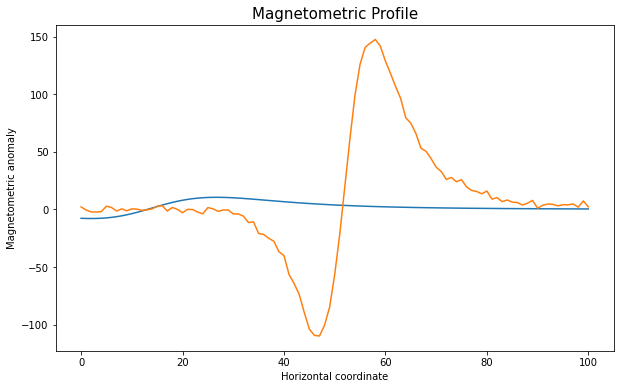

In [17]:
# Let's see the profile from this first candidate to our solution and compare with the observations

import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.xlabel('Horizontal coordinate')
plt.ylabel('Magnetometric anomaly')
plt.title('Magnetometric Profile', fontsize = 15)
plt.plot(anomaly.iloc[:,0], anomc)
plt.plot(anomaly.iloc[:,0], anomaly.iloc[:,1])

In [18]:
# It doesn't seem to fit very well, let's continue our work

In [19]:
# Evaluating the model with Rrms norm
# for the T model will be rms, but the others will be norm vector

Rrms = np.sqrt(np.sum((obs_data[:, 1] - anomc) ** 2) / dataset_len)

In [20]:
Rrms

52.865829775898234

In [21]:
norma = np.zeros(n_modelos)

for j in range(n_modelos):
    xq = conj_sol[0, j]
    zq = conj_sol[1, j]
    mom = conj_sol[2, j]

    for i in range(dataset_len):
        
        xp = obs_data[i, 0]

        bx, by, bz = dipole(xq,yq,zq,mi,md,mom,xp,yp,zp)
        bxx = bx + fx
        byy = by + fy
        bzz = bz + fz
        bt = np.sqrt(bxx**2 + byy**2 + bzz**2)

        anomc[i] = bt - F
        
    norma[j] = np.sqrt(np.sum((obs_data[:, 1] - anomc) ** 2) / dataset_len)

In [22]:
# Here we will chose the number of iterations to repeat the process until we reach this number of iterations
iteracoes = 5000

In [23]:
convergence = np.zeros((iteracoes, 2))

In [24]:
cont = 0
while cont != iteracoes:
    
    vmax = np.max(norma)
    imax = np.where(norma == vmax)[0][0]

    if vmax < Rrms:
        k = random.randint(0,n_modelos - 1)
        l = random.randint(0,n_modelos - 1)
        m = random.randint(0,n_modelos - 1)

        # building the mean from n models chosen randomly
        for i in range(3):
            P[i] = (conj_sol[i, k] + conj_sol[i, l] + conj_sol[i, m]) / 3

        # Getting randomly another integer between 0 and the number of models  for the n + 1 model from theory
        n = random.randint(0,n_modelos - 1)
        
        # The mean between the P model and n + 1 model from our set of models
        for i in range(3):
            finalmod[i] = 2 * P[i] - conj_sol[i, n]

        xq=finalmod[0]
        zq=finalmod[1]
        mom=finalmod[2]
        
        for i in range(dataset_len):
    
            bx, by, bz = dipole(xq,yq,zq,mi,md,mom,obs_data[i, 0],yp,zp)

            bxx = bx + fx
            byy = by + fy
            bzz = bz + fz
            bt = np.sqrt(bxx**2 + byy**2 + bzz**2)

            anomc[i] = bt - F

        # Evaluating the model with Rrms norm
        # for the T model will be rms, but the others will be norm vector
        Rrms = np.sqrt(np.sum((obs_data[:, 1] - anomc) ** 2) / dataset_len)
            
        for j in range(n_modelos):
            xq = conj_sol[0, j]
            zq = conj_sol[1, j]
            mom = conj_sol[2, j]

            for i in range(dataset_len):

                xp = obs_data[i, 0]

                bx, by, bz = dipole(xq,yq,zq,mi,md,mom,xp,yp,zp)
                bxx = bx + fx
                byy = by + fy
                bzz = bz + fz
                bt = np.sqrt(bxx**2 + byy**2 + bzz**2)

                anomc[i] = bt - F

            norma[j] = np.sqrt(np.sum((obs_data[:, 1] - anomc) ** 2) / dataset_len)
            
    else:
        conj_sol[0, imax] = finalmod[0]
        conj_sol[1, imax] = finalmod[1]
        conj_sol[2, imax] = finalmod[2]
        
        k = random.randint(0,n_modelos - 1)
        l = random.randint(0,n_modelos - 1)
        m = random.randint(0,n_modelos - 1)
        
         # building the mean from n models chosen randomly
        for i in range(3):
            P[i] = (conj_sol[i, k] + conj_sol[i, l] + conj_sol[i, m]) / 3
            
        # Getting randomly another integer between 0 and the number of models  for the n + 1 model from theory
        n = random.randint(0,n_modelos - 1)
        
        # The mean between the P model and n + 1 model from our set of models
        for i in range(3):
            finalmod[i] = 2 * P[i] - conj_sol[i, n]
            
        xq=finalmod[0]
        zq=finalmod[1]
        mom=finalmod[2]
        
        for i in range(dataset_len):
    
            bx, by, bz = dipole(xq,yq,zq,mi,md,mom,obs_data[i, 0],yp,zp)

            bxx = bx + fx
            byy = by + fy
            bzz = bz + fz
            bt = np.sqrt(bxx**2 + byy**2 + bzz**2)

            anomc[i] = bt - F
            
        # Evaluating the model with Rrms norm
        # for the T model will be rms, but the others will be norm vector
        Rrms = np.sqrt(np.sum((obs_data[:, 1] - anomc) ** 2) / dataset_len)
        
        for j in range(n_modelos):
            xq = conj_sol[0, j]
            zq = conj_sol[1, j]
            mom = conj_sol[2, j]

            for i in range(dataset_len):

                xp = obs_data[i, 0]

                bx, by, bz = dipole(xq,yq,zq,mi,md,mom,xp,yp,zp)
                bxx = bx + fx
                byy = by + fy
                bzz = bz + fz
                bt = np.sqrt(bxx**2 + byy**2 + bzz**2)

                anomc[i] = bt - F

            norma[j] = np.sqrt(np.sum((obs_data[:, 1] - anomc) ** 2) / dataset_len)



    convergence[cont, 0] = cont
    convergence[cont, 1] = np.min(norma)
    
    cont = cont + 1

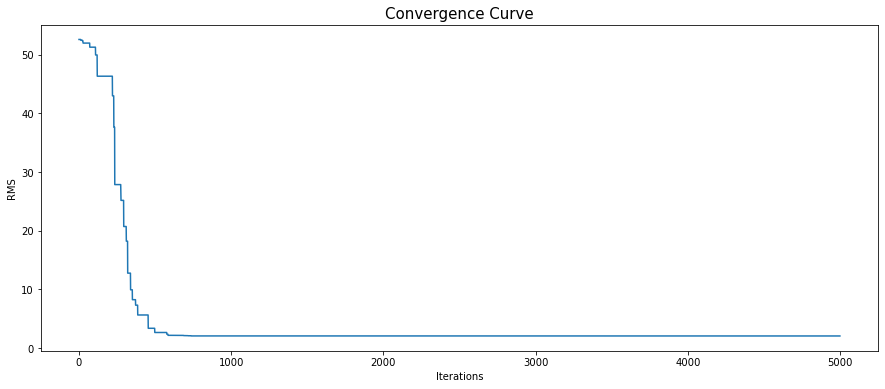

In [25]:
# Let's draw the convergence curve to see how our algoritm walked to his solution 

plt.figure(figsize = (15,6))
plt.xlabel('Iterations')
plt.ylabel('RMS')
plt.title('Convergence Curve', fontsize = 15)
plt.plot(convergence[:, 0], convergence[:, 1])

In [26]:
# Catching the lowest solution delivered by our evaluation of rms

vmin = np.min(norma)
imin = np.where(norma == vmin)[0][0]

xq=conj_sol[0, imin]
zq=conj_sol[1, imin]
mom=conj_sol[2, imin]

We have our solution!

In [27]:
print("xq", xq, "zq", zq, "mom", mom, "Rrms:", vmin)

xq 51.282629311622564 zq 9.695196471287684 mom 1943.3355372120327 Rrms: 2.056924147937284


Let's see the anomaly generated by the calculated model and the observations

In [28]:
# Evaluating the anomaly from the solution model again to build visualization

calc_and_obs_data = np.zeros((obs_data.shape[0], 3))

for i in range(obs_data.shape[0]):
    
    xp = obs_data[i, 0]
    
    bx, by, bz = dipole(xq,yq,zq,mi,md,mom,xp,yp,zp)
    bxx = bx + fx
    byy = by + fy
    bzz = bz + fz
    bt = np.sqrt(bxx**2 + byy**2 + bzz**2)
    
    anomc[i] = bt - F

    calc_and_obs_data[i, 0] = obs_data[i, 0]
    calc_and_obs_data[i, 1] = anomc[i]
    calc_and_obs_data[i, 2] = obs_data[i, 1]

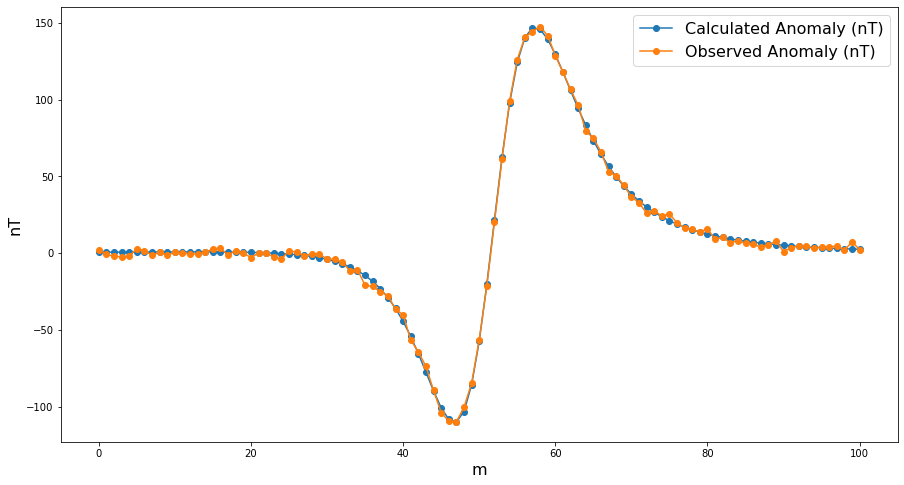

In [29]:
x = calc_and_obs_data[:, 0]
calc = calc_and_obs_data[:, 1]
obs = calc_and_obs_data[:, 2]

plt.figure(figsize=(15,8))
plt.plot(x, calc, 'o-', label='Calculated Anomaly (nT)')
plt.plot(x, obs, 'o-', label='Observed Anomaly (nT)')
plt.xlabel('m', fontsize=16)
plt.ylabel('nT', fontsize=16)
plt.legend(loc='best', numpoints=1, fontsize=16)
plt.show()

It seems to be way better fitting than the first version that we tried above.

We saw in the convergence curve that we don't need to do 5000 iterations. 1000 iterations should bring us satisfactory result. Below, there are fields generated by solutions from some other number of iterations. We can see the evolution of the curve from the solutions.

<h3 style="color:blue;text-align:center;">750 iterations</h3>

<img src = 'images/750.png'>

<h3 style="color:blue;text-align:center;">850 iterations</h3>

<img src = 'images/850.png'>

<h3 style="color:blue;text-align:center;">1000 iterations</h3>

<img src = 'images/1000.png'>